In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import pygrib
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'matplotlib.pyplot',
 'numpy',
 'pandas',
 'xarray',
 'time',
 'pyarrow',
 'pygrib',
 'cartopy',
 'cartopy.crs',
 'cartopy.feature',
 'descartes',
 'geopandas',
 'types']

In [3]:
def v_wind_eval(orig_height, target_height, wind_speeds, surface_roughness):
    """Evaluates the wind speed at a certain height using formula, outputs array"""
    
    alpha = 0.5*(surface_roughness/10)**0.2
    speeds = wind_speeds*(target_height/orig_height)**alpha
    
    return speed_arr

def wind_power_output(pwr_crv_str, speed_arr):
    """Uses power curve data from NRES and array of speeds to create correlated array of power outputs in MW of 
    that wind turbine in relation to each of those speeds. Power curve array has 3 columns: speed, power output, 
    capacity factor"""

    power_curve = np.loadtxt(pwr_crv_str,delimiter=",", dtype=str)
    power_curve = power_curve[1:,:].astype('float')
    speed_limited = np.where((speed_arr>25) | (speed_arr<0),0,speed_arr) #curtails power output above max
    power_outputs = np.interp(speed_limited,power_curve[:,0],power_curve[:,1])
    
    return power_outputs

In [4]:

# Estimate memory usage
process = psutil.Process()
print(f"Memory usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")



Memory usage: 186.21 MB


In [5]:

file_path = file_path = "/share/data1/xzcaplbl/data/1982_to_2022.grib"
# Open the GRIB file using xarray
x = xr.open_dataset(file_path, engine='cfgrib')

# Print the dataset information
print(x)

# Access specific variables or slices
u100_data = x['u100'].values
v100_data = x['v100'].values
latitude_values = x['latitude'].values
longitude_values = x['longitude'].values
time_value = x["time"].values




/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.29.0
  warnings.warn(


<xarray.Dataset>
Dimensions:     (time: 359400, latitude: 81, longitude: 119)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1982-01-01 ... 2022-12-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 70.0 69.75 69.5 69.25 ... 50.5 50.25 50.0
  * longitude   (longitude) float64 -12.5 -12.25 -12.0 ... 16.5 16.75 17.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    u100        (time, latitude, longitude) float32 ...
    v100        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-10T12:58 GRIB to CDM+CF via cfgrib-0.9.1...


In [6]:


# Estimate memory usage
process = psutil.Process()
print(f"Memory usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")

Memory usage: 27255.26 MB


In [7]:
ds = xr.Dataset(
    {'latitude': (['lat'], latitude_values),
     'longitude': (['lon'], longitude_values),
     'u100': (['time', 'lat', 'lon'], u100_data),
     'v100': (['time', 'lat', 'lon'], v100_data)},
    coords={'time': ('time', time_value)}
)
wind_speed = np.sqrt(u100_data**2 + v100_data**2)

ds

<xarray.Dataset>
Dimensions:    (lat: 81, lon: 119, time: 359400)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 ... 2022-12-31T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float64 70.0 69.75 69.5 69.25 ... 50.75 50.5 50.25 50.0
    longitude  (lon) float64 -12.5 -12.25 -12.0 -11.75 ... 16.25 16.5 16.75 17.0
    u100       (time, lat, lon) float32 -10.55 -10.63 -10.71 ... 1.639 2.368
    v100       (time, lat, lon) float32 -4.383 -4.479 -4.569 ... 6.179 5.545

In [8]:


# Estimate memory usage
process = psutil.Process()
print(f"Memory usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")

Memory usage: 40470.62 MB


In [9]:
df = ds.to_dataframe()
df

latitude  longitude       u100      v100
lat lon time                                                         
0   0   1982-01-01 00:00:00      70.0      -12.5 -10.551697 -4.382889
        1982-01-01 01:00:00      70.0      -12.5 -10.001892 -4.160858
        1982-01-01 02:00:00      70.0      -12.5  -9.601166 -3.808136
        1982-01-01 03:00:00      70.0      -12.5  -8.973923 -3.667847
        1982-01-01 04:00:00      70.0      -12.5  -8.164856 -3.258514
...                               ...        ...        ...       ...
80  118 2022-12-31 19:00:00      50.0       17.0   2.089096  5.778671
        2022-12-31 20:00:00      50.0       17.0   2.097702  5.201706
        2022-12-31 21:00:00      50.0       17.0   1.910965  5.501007
        2022-12-31 22:00:00      50.0       17.0   2.404373  5.254974
        2022-12-31 23:00:00      50.0       17.0   2.368179  5.544617

[3464256600 rows x 4 columns]

In [10]:
grbs = pygrib.open(file_path)
grbs.seek(0)

In [11]:
grbs.seek(0)
grb = grbs[1]

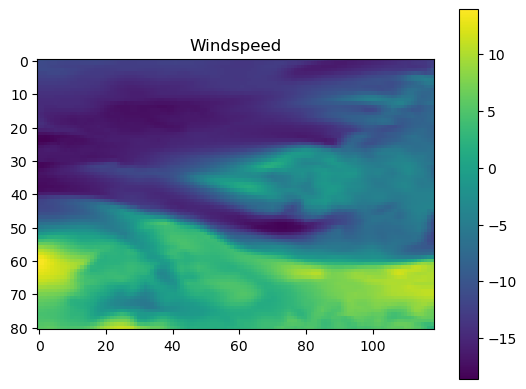

In [12]:
plt.imshow(grb.values)
plt.colorbar()
plt.title('Windspeed')
plt.show()

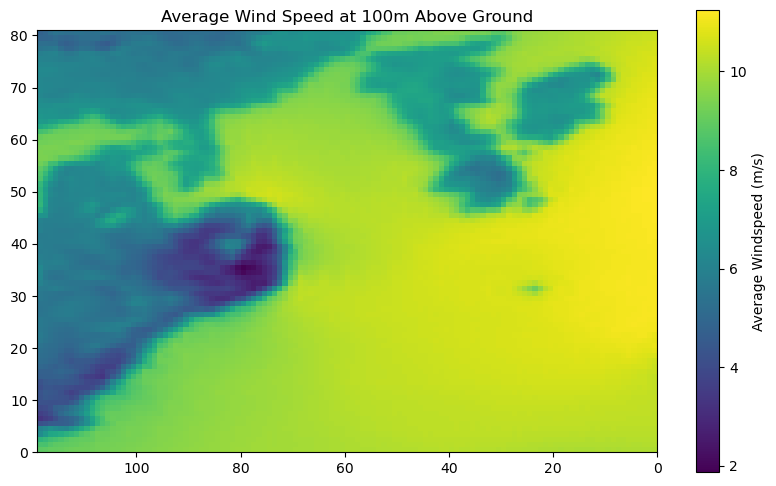

In [13]:
# Extract u100m and v100m components
u100_data = x['u100'].values
v100_data = x['v100'].values

# Calculate the wind speed magnitude
wind_speed = np.sqrt(u100_data**2 + v100_data**2)

# Calculate the average wind speed over all time steps
average_wind_speed = np.mean(wind_speed, axis=0)

# Plot the average wind speed
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(average_wind_speed, cmap='viridis', shading='auto')
plt.colorbar(label='Average Windspeed (m/s)')
plt.title('Average Wind Speed at 100m Above Ground')

plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_xlim(plt.gca().get_xlim()[::-1])

# Show the plot
plt.show()

# Close the GRIB file
grbs.close()

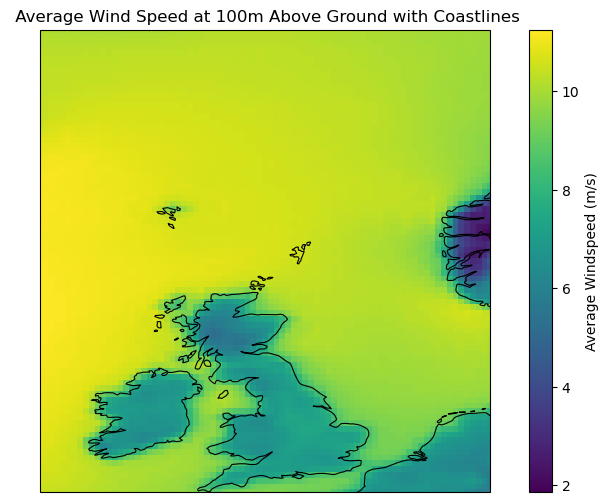

In [14]:


# Extract u100m and v100m components
u100_data = x['u100'].values
v100_data = x['v100'].values

# Calculate the wind speed magnitude
wind_speed = np.sqrt(u100_data**2 + v100_data**2)

# Calculate the average wind speed over all time steps
average_wind_speed = np.mean(wind_speed, axis=0)

# Flip the average wind speed upside down
flipped_wind_speed = np.flipud(average_wind_speed)
flipped_longitude = np.flipud(ds['longitude'])
flipped_latitude= np.flipud(ds['latitude'])



##########################

# Assuming flipped_wind_speed contains your wind speed data (flipped if needed)
flipped_wind_speed = np.flipud(average_wind_speed)

# Create a map with coastlines and wind speed overlay
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12.5, 7, 50, 70])

# Plot wind speed using pcolormesh
pcm1 = ax.pcolormesh(ds['longitude'], flipped_latitude, flipped_wind_speed, cmap='viridis', shading='auto')
plt.colorbar(pcm1, label='Average Windspeed (m/s)')

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')



# Set the title
plt.title(' Average Wind Speed at 100m Above Ground with Coastlines')
# Show the plot
plt.show()

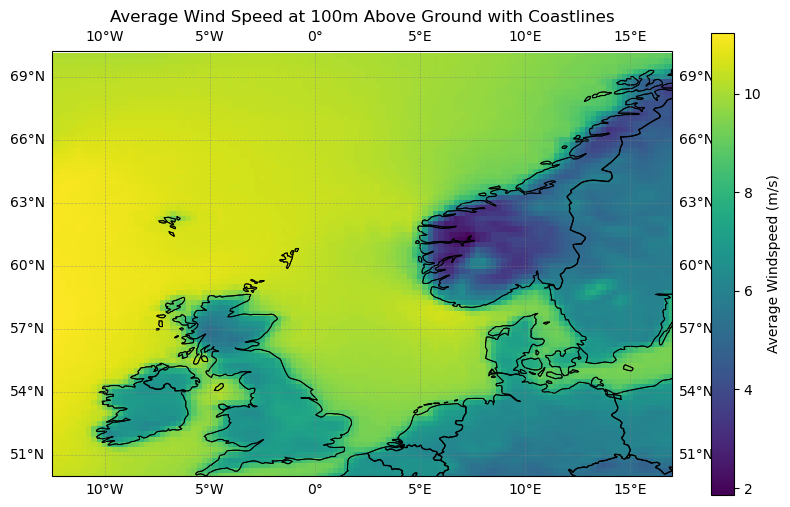

In [15]:
# Assuming flipped_wind_speed contains your wind speed data (flipped if needed)
flipped_wind_speed = np.flipud(average_wind_speed)

# Create a map with coastlines and wind speed overlay
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12.5, 17, 50, 70])

# Create latitude and longitude grids
lon, lat = np.meshgrid(ds['longitude'], flipped_latitude)

# Plot wind speed using pcolormesh
pcm1 = ax.pcolormesh(lon, lat, flipped_wind_speed, cmap='viridis', shading='auto')
plt.colorbar(pcm1, label='Average Windspeed (m/s)')


# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none'
)
ax.add_feature(countries, linestyle='-', linewidth=0.5)

# Add borders to specific countries (e.g., Germany and France)
borders = cfeature.BORDERS
ax.add_feature(borders, linestyle='-', linewidth=1, edgecolor='black', facecolor='none', zorder=10)


ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')


# Set the title
plt.title('Average Wind Speed at 100m Above Ground with Coastlines')
plt.grid()

# Show the plot
plt.show()



In [ ]:
# Assuming flipped_wind_speed contains your wind speed data (flipped if needed)
flipped_wind_speed = np.flipud(average_wind_speed)

# Create a map with coastlines and wind speed overlay
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12.5, 17, 50, 70])

# Create latitude and longitude grids
lon, lat = np.meshgrid(ds['longitude'], flipped_latitude)

# Plot wind speed using pcolormesh
pcm1 = ax.pcolormesh(lon, lat, flipped_wind_speed, cmap='viridis', shading='auto')
plt.colorbar(pcm1, label='Average Windspeed (m/s)')

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none'
)
ax.add_feature(countries, linestyle='-', linewidth=0.5)

# Add borders to specific countries (e.g., Germany and France)
borders = cfeature.BORDERS
ax.add_feature(borders, linestyle='-', linewidth=1, edgecolor='black', facecolor='none', zorder=10)

ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot the given data points
data_points = [
    [[50., -12.5], [57.5, 10.], [53., 5.], [60., 5.], [66., 13.]],
    [[58.25, 10.], [58., 10.25], [58., 9.75], [58.25, 9.75], [58.25, 10.25]],
    [[61.25, -5.], [61., -4.75], [61., -5.25], [61.25, -5.25], [61.25, -4.75]],
    [[51.25, -7.], [51., -6.75], [51., -7.25], [51.25, -7.25], [51.25, -6.75]],
    [[66.25, 7.], [66., 7.25], [66., 6.75], [66.25, 6.75]]
]

markers = ['x', 'o', '^', 's', 'd']
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, points in enumerate(data_points):
    lons, lats = zip(*points)
    ax.scatter(lons, lats, marker=markers[i], color=colors[i], transform=ccrs.PlateCarree())

# Set the title
plt.title('Average Wind Speed at 100m Above Ground with Coastlines')

# Show the plot
plt.show()
